In [18]:
import pandas as pd
import numpy as np
import time
import itertools
import gzip
import openTSNE
from openTSNE.affinity import PerplexityBasedNN
from joblib import dump, load
import matplotlib.pyplot as plt

### Loading gene expression pre-processed data and corresponding metadata

In [32]:
data_file = gzip.GzipFile('data/originaldata_HGV_preproc_gzip', "r"); expr_data_preprocessed = np.load(data_file)
#metadata_sampled = pd.read_csv('metadata_sampled')
metadata = pd.read_csv("data/2097-Lungcancer_metadata.csv.gz")

In [ ]:
expr_data_preprocessed.shape

### Create parameters space

In [9]:
def generate_combinations(perplexity_range, early_exagg_range, initial_momentum_range, 
                          final_momentum_range, theta_range):
    """
    Generate combinations of parameters based on specified ranges.

    Parameters:
    - perplexity_range: Tuple containing the start and stop values for perplexity range.
    - early_exagg_range: Tuple containing the start and stop values for early_exagg range.
    - initial_momentum_range: Tuple containing the start and stop values for initial_momentum range.
    - final_momentum_range: Tuple containing the start and stop values for final_momentum range.
    - theta_range: Tuple containing the start and stop values for theta range.

    Returns:
    - A list of parameter combinations.
    """
    # Generate parameter values using np.linspace
    perplexity_values = np.linspace(*perplexity_range, num=18, dtype=int).tolist()
    early_exagg_values = np.linspace(*early_exagg_range, num=15, dtype=int).tolist()
    initial_momentum_values = np.round(np.linspace(*initial_momentum_range, num=5, dtype=float), 1).tolist()
    final_momentum_values = np.round(np.linspace(*final_momentum_range, num=8, dtype=float), 2).tolist()
    theta_values = np.round(np.linspace(*theta_range, num=11, dtype=float), 2).tolist()

    # Generate combinations
    combinations = list(itertools.product(perplexity_values, early_exagg_values, 
                                          initial_momentum_values, final_momentum_values, theta_values))

    return combinations


# Define parameter ranges
perplexity_range = (5, 90)          # perplexity range
early_exagg_range = (4, 32)          # early_exagg range
initial_momentum_range = (0.1, 0.5)  # initial_momentum range
final_momentum_range = (0.8, 1.0)    # final_momentum range
theta_range = (0, 1.0)              # theta range

# Generate combinations
combinations = generate_combinations(perplexity_range,
                                     early_exagg_range,
                                     initial_momentum_range,
                                     final_momentum_range,
                                     theta_range)

# Print first 5 tuples in the list
print(combinations[:5])

[(5, 4, 0.1, 0.8, 0.0), (5, 4, 0.1, 0.8, 0.1), (5, 4, 0.1, 0.8, 0.2), (5, 4, 0.1, 0.8, 0.3), (5, 4, 0.1, 0.8, 0.4)]


### Define a cache dictionary to store computed affinities: kNN search for each data point based on a unique perplexity value

In [13]:
def compute_affinities(X, perplexity_values, n_jobs=2, random_state=1234):
    """
    Compute affinities for multiple perplexity values and cache them.

    Parameters:
    - X: Input data matrix.
    - perplexity_values: List of perplexity values.
    - n_jobs: Number of parallel jobs.
    - random_state: Random seed for reproducibility.

    Returns:
    - A dictionary containing affinities computed for each perplexity value.
    """
    affinity_cache = {}
    
    for perplexity in perplexity_values:
        # Check if affinity for this perplexity has been computed
        if perplexity not in affinity_cache:
            # Compute affinity and store in cache
            affinities = PerplexityBasedNN(X, perplexity=perplexity, n_jobs=n_jobs, random_state=random_state)
            affinity_cache[perplexity] = affinities

    return affinity_cache

In [33]:
%%time
affinity_cache = compute_affinities(X = expr_data_preprocessed,
                                    perplexity_values = np.linspace(*(5, 90),num=18, dtype=int).tolist()
                                    )

# Exploring cached affinity for Perplexity 5
print(dir(affinity_cache[5]))
print(affinity_cache[5].P.A.shape)
print(affinity_cache[5].P.A[:5,:5])
print(affinity_cache[5].P.A.max())

### T-SNE function

In [16]:
def run_openTSNE_with_combinations(combinations, X, affinity_cache, initialization='random', n_jobs=1, 
                                   negative_gradient_method='BH', random_state=1234, 
                                   n_iter=750, verbose=False, dof=1):
    """
    Run openTSNE with a list of parameter combinations.

    Parameters:
    - combinations: List of parameter combinations.
    - X: Input data matrix.
    - affinity_cache: Dictionary containing pre-computed affinities.
    - Other parameters as in the previous function.

    Returns:
    - List of tuples, each containing the combination and the resulting embedding.
    """
    results = []

    for combo in combinations:
        perplexity, early_exagg, initial_momentum, final_momentum, theta = combo

        # Get pre-computed affinities from cache
        affinities = affinity_cache[perplexity]

        # Create TSNE object with the provided parameters
        tsne = openTSNE.TSNE(
            perplexity=perplexity,
            early_exaggeration=early_exagg,
            initialization=initialization,
            n_jobs=n_jobs,
            negative_gradient_method=negative_gradient_method,
            theta=theta,
            n_iter=n_iter,
            verbose=verbose,
            random_state=random_state,
            dof=dof
        )

        start_time = time.time()

        # Fit TSNE with cached affinities
        embedding = tsne.fit(affinities=affinities)

        runtime = time.time() - start_time

        KL_divergence = embedding.kl_divergence
        
        # Append the results
        results.append((combo, embedding, runtime, KL_divergence))

    return results   


### Define parameters grid

In [21]:
perplexity_range = (5, 90)          # perplexity range
early_exagg_range = (4, 32)          # early_exagg range
initial_momentum_range = (0.1, 0.5)  # initial_momentum range
final_momentum_range = (0.8, 1.0)    # final_momentum range
theta_range = (0, 1.0)              # theta range

# Generate combinations
combinations = generate_combinations(perplexity_range, early_exagg_range, initial_momentum_range, 
                                     final_momentum_range, theta_range)


#### Run TSNE with the generated combinations

In [30]:
%%time
combination = [(80, 4, 0.1, 0.8, 0.5)] #[(10, 4, 0.1, 0.8, 0.8)
results = run_openTSNE_with_combinations(combination, X = expr_data_preprocessed, affinity_cache = affinity_cache, verbose=True)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=4, initialization='random', n_iter=750,
     negative_gradient_method='BH', perplexity=80, random_state=1234,
     verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=4.00, lr=494.50 for 250 iterations...
Iteration   50, KL divergence 3.2361, 50 iterations in 8.5539 sec
Iteration  100, KL divergence 3.1892, 50 iterations in 5.3760 sec
Iteration  150, KL divergence 3.0716, 50 iterations in 5.3753 sec
Iteration  200, KL divergence 3.0064, 50 iterations in 5.5361 sec
Iteration  250, KL divergence 3.0750, 50 iterations in 5.2444 sec
   --> Time elapsed: 30.09 seconds
===> Running optimization with exaggeration=1.00, lr=1978.00 for 750 iterations...
Iteration   50, KL divergence 1.9644, 50 iterations in 3.7398 sec
Iteration  100, KL divergence 1.9444, 50 iterations in 3.6342 sec
Iteration  150, KL dive

Parameter combination: (80, 4, 0.1, 0.8, 0.5)
Embedding shape: (1978, 2)
Embedding: <class 'openTSNE.tsne.TSNEEmbedding'>
Embedding: [[-1.06601522  1.86321095]
 [-0.62510922 -0.5583711 ]
 [-0.61951186 -0.52101636]
 ...
 [-0.93565362 -0.72987644]
 [ 1.27877931  2.61297315]
 [-0.73732359 -0.29024049]]
Runtime: 84.32601237297058
KL divergence: [1.9430737852780808]


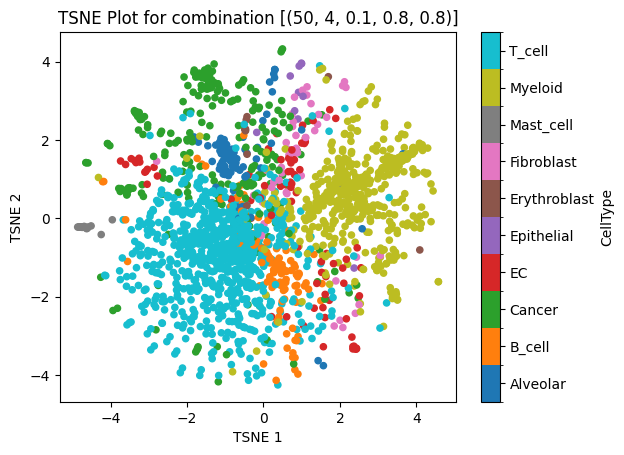

In [31]:
for combo, embedding, runtime, KL_divergence  in results:
    print("Parameter combination:", combo)
    print("Embedding shape:", embedding.shape)
    print("Embedding:", embedding.__class__)
    print("Embedding:", embedding)
    print("Runtime:", runtime)
    print("KL divergence:", [KL_divergence])
    
# Unpack the results
#dump(results, 'results.joblib')
# Unpack the single tuple from results
embedding_X, embedding_Y = results[0][1][:, 0], results[0][1][:, 1]
runtime = results[0][2]
KL_divergence =  results[0][3]
combined_data = pd.DataFrame({
    'TSNE_1': embedding_X,
    'TSNE_2': embedding_Y,
    'CellType': metadata_sampled['CellType']
})
combined_data['CellType'] = pd.Categorical(combined_data['CellType'])

# Plot using DataFrame plot method
combined_data.plot.scatter(x='TSNE_1', y='TSNE_2', c='CellType', cmap = 'tab10')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('TSNE Plot for combination [(50, 4, 0.1, 0.8, 0.8)]')
plt.show()




In [ ]:
dump([combined_data, runtime, KL_divergence], 'combined_data[(50, 4, 0.1, 0.8, 0.8)].joblib')